In [230]:
import numpy as np
import wave
from scipy.io import wavfile
from scipy import signal
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from tensorflow.keras.layers import Convolution2D, BatchNormalization
from librosa.core import stft
import matplotlib.pyplot as plot
import matplotlib.cm as cm
import keras.backend as K

In [3]:
def _wav2array(nchannels, sampwidth, data):
    """data must be the string containing the bytes from the wav file."""
    num_samples, remainder = divmod(len(data), sampwidth * nchannels)
    if remainder > 0:
        raise ValueError('The length of data is not a multiple of '
                         'sampwidth * num_channels.')
    if sampwidth > 4:
        raise ValueError("sampwidth must not be greater than 4.")

    if sampwidth == 3:
        a = np.empty((num_samples, nchannels, 4), dtype=np.uint8)
        raw_bytes = np.fromstring(data, dtype=np.uint8)
        a[:, :, :sampwidth] = raw_bytes.reshape(-1, nchannels, sampwidth)
        a[:, :, sampwidth:] = (a[:, :, sampwidth - 1:sampwidth] >> 7) * 255
        result = a.view('<i4').reshape(a.shape[:-1])
    else:
        # 8 bit samples are stored as unsigned ints; others as signed ints.
        dt_char = 'u' if sampwidth == 1 else 'i'
        a = np.fromstring(data, dtype='<%s%d' % (dt_char, sampwidth))
        result = a.reshape(-1, nchannels)
    return result


def readwav(file):
    """
    Read a wav file.
    Returns the frame rate, sample width (in bytes) and a numpy array
    containing the data.
    This function does not read compressed wav files.
    """
    wav = wave.open(file)
    rate = wav.getframerate()
    nchannels = wav.getnchannels()
    sampwidth = wav.getsampwidth()
    nframes = wav.getnframes()
    data = wav.readframes(nframes)
    wav.close()
    array = _wav2array(nchannels, sampwidth, data)
    return rate, sampwidth, array

In [253]:
X_data = np.zeros(shape=(60999,45056))
print(X_data.shape)

for r in range(0, 60999):
    audio = readwav('/Users/josephcleveland/Dataset/samp' + str(r) + '.wav')[2]
    audio = audio.T[0]
    if(audio.shape != 45056):
        padded = np.zeros(shape=(45056))
        padded[:np.shape(audio)[0]] = audio
        audio = padded
    X_data[r] = audio
    


(60999, 45056)


/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(705, 129)


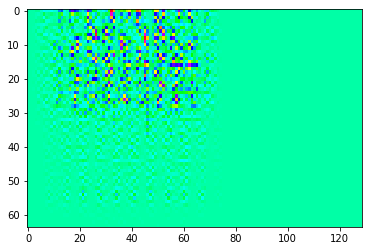

In [236]:
spect = stft(X_data[15],n_fft=1408)
print(spect.shape)
plot.imshow(spect.real[0:64], aspect='auto', cmap=cm.gist_rainbow)
plot.show()

In [254]:
Y_data = np.zeros(shape=(60999, 23))
mat = np.genfromtxt('/Users/josephcleveland/Dataset/mat.txt', delimiter=',')
Y_data = mat[0:60999]
#for i in range(0, 10000):
#    onehot = to_categorical(mat[i], 16)
#    Y_data[i] = onehot.ravel()

In [255]:
#X_data = signal.resample(X_data, 16384)
X_train = np.zeros((60999, 64, 64))
for i in range(0, 60999):
    X_train[i] = stft(X_data[i],n_fft=1408)[0:64, 0:64]
Y_train = Y_data
X_train = np.expand_dims(X_train, axis=3)

print(X_train.shape)

/Users/josephcleveland/Summer/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


(60999, 64, 64, 1)


In [458]:
#model = Sequential()
#model.add(BatchNormalization())
#model.add(Convolution2D(96, kernel_size=(64, 1), strides=(4, 1), padding="valid", activation='relu', data_format="channels_last", input_shape=(16384, 1, 1)))
#model.add(Convolution2D(96, kernel_size=(32, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(16, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Convolution2D(257, kernel_size=(8, 1), strides=(4, 1), padding="valid", activation='relu'))
#model.add(Reshape((173, 257, 1)))
#model.add(Reshape((61, 257, 1)))
#model.add(Convolution2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(71, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(4, 3), strides=(3, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'))
#model.add(Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu'))
#model.add(Flatten())
#model.add(Dense(512, activation='relu'))
#model.add(Dense(368, activation='relu'))

#model.compile(loss='categorical_crossentropy',
#              optimizer='adam',
#              metrics=['accuracy'])

In [256]:
inputs = Input(shape=(64,64,1))

# a layer instance is callable on a tensor, and returns a tensor
x = BatchNormalization()(inputs)
x = Convolution2D(32, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(71, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(4, 3), strides=(3, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu')(x)
x = Convolution2D(128, kernel_size=(3, 3), strides=(2, 1), padding="same", activation='relu')(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(23)(x)
# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [257]:

model.fit(X_train, Y_train, 
          batch_size=16, epochs=10, verbose=1, validation_split=0.1)

Train on 54899 samples, validate on 6100 samples
Epoch 1/10
54899/54899 [==============================] - 86s 2ms/sample - loss: 19.2103 - accuracy: 0.0644 - val_loss: 17.8719 - val_accuracy: 0.0803
Epoch 2/10
54899/54899 [==============================] - 78s 1ms/sample - loss: 17.4221 - accuracy: 0.0837 - val_loss: 16.9683 - val_accuracy: 0.0907
Epoch 3/10
54899/54899 [==============================] - 83s 2ms/sample - loss: 16.8042 - accuracy: 0.0927 - val_loss: 16.4973 - val_accuracy: 0.0949
Epoch 4/10
54899/54899 [==============================] - 82s 1ms/sample - loss: 16.3616 - accuracy: 0.1003 - val_loss: 16.5174 - val_accuracy: 0.0972
Epoch 5/10
54899/54899 [==============================] - 87s 2ms/sample - loss: 16.0301 - accuracy: 0.1060 - val_loss: 16.1193 - val_accuracy: 0.1043
Epoch 6/10
54899/54899 [==============================] - 88s 2ms/sample - loss: 15.7157 - accuracy: 0.1113 - val_loss: 16.0447 - val_accuracy: 0.1080
Epoch 7/10
54899/54899 [=====================

In [131]:
model.build(input_shape=(45056, 1, 1))
print(model.summary())
print()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
batch_normalization_v2_2 (Ba (None, 64, 64, 1)         4         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 71)        20519     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 6, 8, 128)         109184    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 3, 4, 128)         147584    
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 2, 2, 128)         1475

In [258]:
o = model.predict(X_train)

In [261]:
print(o[1])
print(np.shape(o))

[ 6.182178   7.0129404  5.2405615  6.3629007  6.918915   6.602991
  9.891388   9.643138   7.7352896  8.138434   9.469395  10.418435
  4.9191556  5.662291  10.876575   9.983708  10.206257  10.091449
  8.344444   7.519502  10.236987   2.6337261  7.840869 ]
(60999, 23)


In [227]:
group = 0
classes = np.zeros((o.shape[0], 23))
samp = 1
for s in range(0, o.shape[0]):
    for i in range(0, 23):
        maxVal = o[s, i * 16]
        maxI = 0
        for j in range(0, 16):
            v = o[s, (i*16) + j]
            if v > maxVal:
                maxVal = o[s, (i*16) + j]
                maxI = j
        classes[s, i] = maxI
print(classes)

[[ 6. 14. 12. ...  3.  0.  1.]
 [ 6. 14. 12. ...  3.  0.  1.]
 [ 6. 14. 12. ...  3.  0.  1.]
 ...
 [ 6. 14. 12. ...  3.  0.  1.]
 [ 6. 14. 12. ...  3.  0.  1.]
 [ 6. 14. 12. ...  3.  0.  1.]]


In [228]:
print(classes[0])
print(mat[0])

[ 6. 14. 12.  5. 11.  2.  2. 13.  9.  8. 11. 10.  9. 15.  8.  2.  0.  7.
  5. 12.  3.  0.  1.]
[ 6.  2.  3. 13. 13. 15. 15. 11. 12.  8. 14. 12.  7.  2.  7.  1.  0.  1.
  3. 11.  3.  3.  3.]


In [229]:
average_dist = np.zeros(23)

for p in range(0, 23):
    dist_total = 0
    for i in range(0, 987):
        dist_total += np.absolute(classes[i, p] - mat[i, p])
    average_dist[p] = dist_total / 987
    
print(average_dist)


[3.9331307  6.48328267 5.11448835 4.295846   4.99189463 5.87234043
 5.77912867 5.80141844 4.03850051 3.91995947 4.67071935 4.35157042
 4.17426545 7.41033435 4.01823708 5.93414387 7.48530902 3.9118541
 4.45997974 5.29989868 5.06585613 7.42654509 6.42654509]


In [594]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())